### Extended Exercise

Download the Quandl dataset "Capital Market Yields – Government Bonds - Daily" from Quandl (code `RBA/F02`), and perform the following steps:

1. Split the data into a training set and a testing set. The test set contains the last row of the data. The training set contains all the previous data.
2. *With only the training dataset*, fit a PCA model and extract the principle components
3. How many principle components are needed to fit at least 99% of the variance in the data?
4. Fit a OLS estimator on the lagged data, *for each principle component*. I explain this further below.
5. Project the data into the test period, by taking the bias and coefficients of the OLS and predicting the next values.
6. Map the projections onto the original data space, by taking the PCA's inverse, to get the actual predicted values
7. Calculate the sum of squared error for your predictions.



In step 4 above, I ask that we fit an OLS on each principle component. If we have a principle component $C$, we want to use the value $c_{n-1}$ to predict the value $c_{n}$ using the linear equation $c_n = \beta_0 + \beta_1 c_{n-1}$. In other words, we fit a linear model saying "given the a value of this variable in a time series, what is the next value?". This type of analysis, moving average, will be reviewed further in a future notebook (1.6.1). 


Note: This exercise fails for some versions of statsmodels, including different computers running 0.9.0. There is a simple fix, noted below where the error is.

In [1]:
%run setup.ipy

ERROR:root:File `'setup.ipy.py'` not found.


In [2]:
# Solution

import quandl

In [3]:
bonds = quandl.get("RBA/F02")

In [4]:
bonds = bonds[bonds.columns[:4]]

In [5]:
bonds.columns = ["2Year", "3Year", "5Year", "10Year"]  # I plan to use statsmodels, so no spaces in variable names!

In [6]:
bonds.head()

,2Year,3Year,5Year,10Year
Date,,,,
2013-05-20,2.480,2.530,2.760,3.220
2013-05-21,2.520,2.570,2.795,3.255
2013-05-22,2.535,2.580,2.805,3.265
2013-05-23,2.530,2.585,2.825,3.295
2013-05-24,2.540,2.595,2.840,3.310


In [7]:
bonds.plot()

In [8]:
training = bonds.iloc[:len(bonds)-1].copy()
testing = bonds.iloc[len(bonds)-1:].copy()

In [9]:
len(training), len(testing), len(bonds)

(1514, 1, 1515)

In [10]:
# Confirm we have no overlap
training.index.intersection(testing.index)

DatetimeIndex([], dtype='datetime64[ns]', name='Date', freq=None)

In [11]:
# Confirm we didn't miss anything
(training.index.union(testing.index) == bonds.index).all()

True

In [12]:
from sklearn.decomposition import PCA

In [13]:
model = PCA()

In [14]:
model.fit(training)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [15]:
model.explained_variance_ratio_

array([9.84317967e-01, 1.25451480e-02, 2.98756705e-03, 1.49317754e-04])

In [16]:
# Note - only two features are needed!
9.8e-01 > 0.99

False

In [17]:
# You can simplify the above using this parameter:
model = PCA(n_components=0.99)  # i.e. explain 95% or more
model.fit(training)

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [18]:
X_training_proj = model.transform(training)  # Project the data onto the components

In [19]:
X_training_proj.shape

(1514, 2)

In [20]:
from matplotlib import pyplot as plt

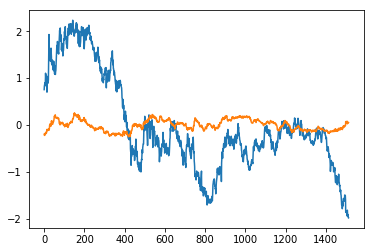

In [21]:
plt.plot(X_training_proj)

In [22]:
import statsmodels.api as sm
import numpy as np
# Store estimators for later use
estimators = []

# Predictions for values. I'll just append here, and transpose at the end
Y_pred = []
Y_actual = []

# Iterate over all principle components:
for i in range(model.n_components_):

    # Here, we lag X compared to Y. X will be one time period behind Y
    X = X_training_proj[:-1, i]
    Y = X_training_proj[1:, i]
    Y_actual.append(Y)


    X = sm.add_constant(X)

    # Fit an OLS model and get a summary
    est = sm.OLS(Y, X).fit()
    estimators.append(est)
    print("Estimator {}: R2 = {:.3f}".format(i, est.rsquared))
    Y_pred.append(est.predict(X))
    
Y_pred = np.array(Y_pred).transpose()
Y_actual = np.array(Y_actual).transpose()  # Challenge - can you compute this using NumPy outside the loop?

Estimator 0: R2 = 0.994
Estimator 1: R2 = 0.976


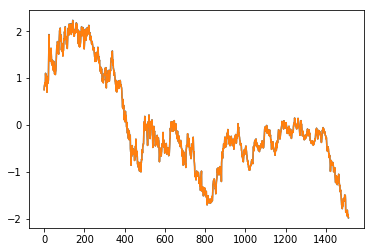

In [23]:
plt.plot(X_training_proj[:,0])
plt.plot(Y_pred[:,0])  # Very close!

In [24]:
Y_actual[:5]  # Note: this is projected onto the components of the PCA!

array([[ 0.82854666, -0.21165555],
       [ 0.85007914, -0.21861267],
       [ 0.87956395, -0.19715205],
       [ 0.9049668 , -0.19738715],
       [ 0.83715122, -0.19311534]])

In [25]:
Y_actual_original_space = model.inverse_transform(Y_actual)
Y_pred_original_space = model.inverse_transform(Y_pred)

In [26]:
Y_actual_original_space[:5]

array([[2.5026558 , 2.58232715, 2.81036324, 3.24342046],
       [2.51533851, 2.59451078, 2.82154773, 3.25223322],
       [2.51207196, 2.59955972, 2.83794003, 3.2842495 ],
       [2.52172571, 2.61093996, 2.85141202, 3.29977885],
       [2.49352747, 2.57919097, 2.81557381, 3.26066766]])

In [27]:
# Compute sum of squared error:
np.sum((Y_pred_original_space - Y_actual_original_space)** 2)

10.020585769074154

In [28]:
# Let's see how it compares to the testing data

In [29]:
testing_proj = model.transform(testing)
testing_proj

array([[-2.07706719,  0.07938362]])

In [30]:
testing_proj[:,i]

array([0.07938362])

In [31]:
X[0]

array([ 1.        , -0.19375164])

In [32]:
#
testing_prediction = []
for i in range(model.n_components_):
    # Create a data row - remember our estimators have a constant, so we need that
    row = [1, testing_proj[:,i]]
    # Reshape, so it is a (1, 2), rather than just a (2,) array. This is the shape statsmodels requires
    row = np.reshape(row, (1, 2))
    # Predict this row
    p = est.predict(row)
    # Statsmodels produces a prediction for each row - we just want the value.
    # Transofrm the (1, 1) result into just a (1,), and append to our predictions
    
    # Potential error here:
    testing_prediction.append(p[0])  # If this errors, try p[0][0]

# testing_prediction now contains the predicted, projected values for the last row
testing_prediction

[-2.050442147291337, 0.07853803293296605]

In [33]:
# Unproject those value, i.e. transform back to the original space
predictions = model.inverse_transform(testing_prediction)
predictions

array([1.23307661, 1.19361555, 1.29270013, 1.65309461])

In [34]:
testing  # Actual values for the last row

,2Year,3Year,5Year,10Year
Date,,,,
2019-05-16,1.22,1.19,1.27,1.64


In [35]:
# Sum of squared error
np.sum((predictions - testing.values)** 2)

0.0008708345194396898